In [1]:
import glob

path = "Fri_Jul__7_11:27:58_2023"
frame_id = 400


metadata_path = glob.glob(f"{path}/metadata_*.json")[0]

import json

with open(metadata_path, "r") as f:
    metadata = json.load(f)
    
uuid = metadata["uuid"]
print(uuid)
print(metadata)

AUTOLab+5d05c5aa+2023-07-07-11h-27m-58s
{'uuid': 'AUTOLab+5d05c5aa+2023-07-07-11h-27m-58s', 'lab': 'AUTOLab', 'user': 'Zehan Ma', 'user_id': '5d05c5aa', 'date': '2023-07-07', 'timestamp': '2023-07-07-11h-27m-58s', 'hdf5_path': 'success/2023-07-07/Fri_Jul__7_11:27:58_2023/trajectory.h5', 'building': 'BAIR', 'scene_id': 5207831207, 'success': True, 'robot_serial': 'fr3-295341-1326595', 'r2d2_version': '1.3', 'current_task': 'Use cup to pour something granular (ex: nuts, rice, dried pasta, coffee beans)', 'trajectory_length': 605, 'wrist_cam_serial': '18026681', 'ext1_cam_serial': '22008760', 'ext2_cam_serial': '24400334', 'wrist_cam_extrinsics': [0.27893653522011114, 0.029694952550924192, 0.46967156978163704, 2.7059995039521683, -0.19578476831931502, 1.8899274488581175], 'ext1_cam_extrinsics': [0.38394799416047826, 0.5194058026771122, 0.3380818926772482, -1.9916617096199483, -0.18304978168904396, -2.2208430828155064], 'ext2_cam_extrinsics': [0.19616185036208578, -0.41135108683927457, 0.3

In [2]:
import json

with open("cam2cam_extrinsics.json") as f:
    cam2cam_extrinsics = json.load(f)

with open("cam2base_extrinsics.json") as f:
    cam2base_extrinsics = json.load(f)

with open("cam2base_extrinsic_superset.json") as f:
    cam2base_extrinsic_superset = json.load(f)

print(cam2base_extrinsic_superset[uuid])

{'relative_path': 'AUTOLab/success/2023-07-07/Fri_Jul__7_11:27:58_2023', '24400334': [0.19616185036208578, -0.41135108683927457, 0.30644442259084437, -1.8976352308252302, -0.06218159881797214, -0.765616157339204], '24400334_metric_type': 'IoU', '24400334_quality_metric': 0.6052018072910578, '24400334_source': 'GT', '22008760': [0.38394799416047826, 0.5194058026771122, 0.3380818926772482, -1.9916617096199483, -0.18304978168904396, -2.2208430828155064], '22008760_metric_type': 'IoU', '22008760_quality_metric': 0.8316212106293829, '22008760_source': 'GT'}


In [3]:
import pytransform3d.rotations as pr
# from scipy.spatial.transform import Rotation
import numpy as np

def T_from_xyzrpy(xyzrpy):
    T = np.eye(4)
    T[:3,3] = xyzrpy[:3]
    T[:3,:3] = pr.matrix_from_euler(xyzrpy[3:], 0, 1, 2, True)
    # print(pr.matrix_from_euler(xyzrpy[3:], 0, 1, 2, True))
    # print(Rotation.from_euler("xyz", np.array(xyzrpy[3:])).as_matrix())
    # print(T)
    return T

In [4]:
Tcam2base = T_from_xyzrpy(cam2base_extrinsic_superset[uuid][metadata["ext1_cam_serial"]])
print(Tcam2base)

[[-0.59511223 -0.42578349  0.68157895  0.38394799]
 [-0.7827559   0.11500408 -0.61161039  0.5194058 ]
 [ 0.18202924 -0.89748676 -0.40172487  0.33808189]
 [ 0.          0.          0.          1.        ]]


In [5]:
def wo_prefix(p):
    return "/".join(p.split("/")[3:])

hdf5_path_wo_prefix = print(wo_prefix(metadata["hdf5_path"]))

trajectory.h5


In [6]:
# import av

# def load_frame(mp4_path, frame_id=0):
#     # Open the video file
#     container = av.open(mp4_path)
    
#     # Get the first video stream
#     stream = container.streams.video[0]
    
#     # Read the first frame
#     for i, frame in enumerate(container.decode(video=0)):
#         if i == frame_id:
#             # Convert frame to numpy array
#             frame_array = frame.to_ndarray(format='rgb24')
#             break
    
#     # Close the container
#     container.close()
    
#     return frame_array

# # Example usage
# first_frame = load_frame(path + "/" + wo_prefix(metadata["ext1_mp4_path"]), 1)
# from PIL import Image
# Image.fromarray(first_frame)

In [7]:
import cv2
import numpy as np
import pyzed.sl as sl

def convert_svo_to_depth(svo_path, frame_id=0):
    # Create a ZED camera object
    zed = sl.Camera()
    
    # Set configuration parameters
    init_params = sl.InitParameters()
    init_params.set_from_svo_file(svo_path)
    
    # Open the camera
    err = zed.open(init_params)
    if err != sl.ERROR_CODE.SUCCESS:
        print(f"Error {err}: Failed to open SVO file")
        return
    
    # Get intrinsics
    left_cam_calibration_params = zed.get_camera_information().camera_configuration.calibration_parameters.left_cam
    fx = left_cam_calibration_params.fx
    fy = left_cam_calibration_params.fy
    cx = left_cam_calibration_params.cx
    cy = left_cam_calibration_params.cy
    intrinsics = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    
    # Create image
    image = sl.Mat()
    depth = sl.Mat()
    point_cloud = sl.Mat()
    
    # Read frames
    i = 0
    while zed.grab() == sl.ERROR_CODE.SUCCESS:
        zed.retrieve_image(image, sl.VIEW.LEFT) # Retrieve image
        zed.retrieve_measure(depth, sl.MEASURE.DEPTH) # Retrieve depth
        zed.retrieve_measure(point_cloud, sl.MEASURE.XYZRGBA)
        
        # zed.retrieve_image(image_r, sl.VIEW.RIGHT) # Retrieve right image
        # zed.retrieve_measure(depth_r, sl.MEASURE.DEPTH_RIGHT) # Retrieve right depth
        # zed.retrieve_measure(point_cloud_r, sl.MEASURE.XYZRGBA_RIGHT)

        # Convert to numpy array
        image_array = image.get_data().copy() # 不加copy好像会导致内存泄漏
        depth_array = depth.get_data().copy()
        point_cloud_array = point_cloud.get_data().copy()
        
        if i == frame_id:
            break
        
        i += 1
    
    # Close the camera
    zed.close()
    
    return image_array, depth_array, point_cloud_array, intrinsics

# Example usage
image_array, depth_array, point_cloud_array, intrinsics = convert_svo_to_depth(path + "/" + wo_prefix(metadata["ext1_svo_path"]), frame_id)

[2025-05-21 07:46:31 UTC][ZED][INFO] Logging level INFO
[2025-05-21 07:46:31 UTC][ZED][INFO] Logging level INFO
[2025-05-21 07:46:31 UTC][ZED][INFO] Logging level INFO
[2025-05-21 07:46:31 UTC][ZED][INFO] [Init]  Depth mode: PERFORMANCE
[2025-05-21 07:46:31 UTC][ZED][INFO] [Init]  Serial Number: S/N 22008760


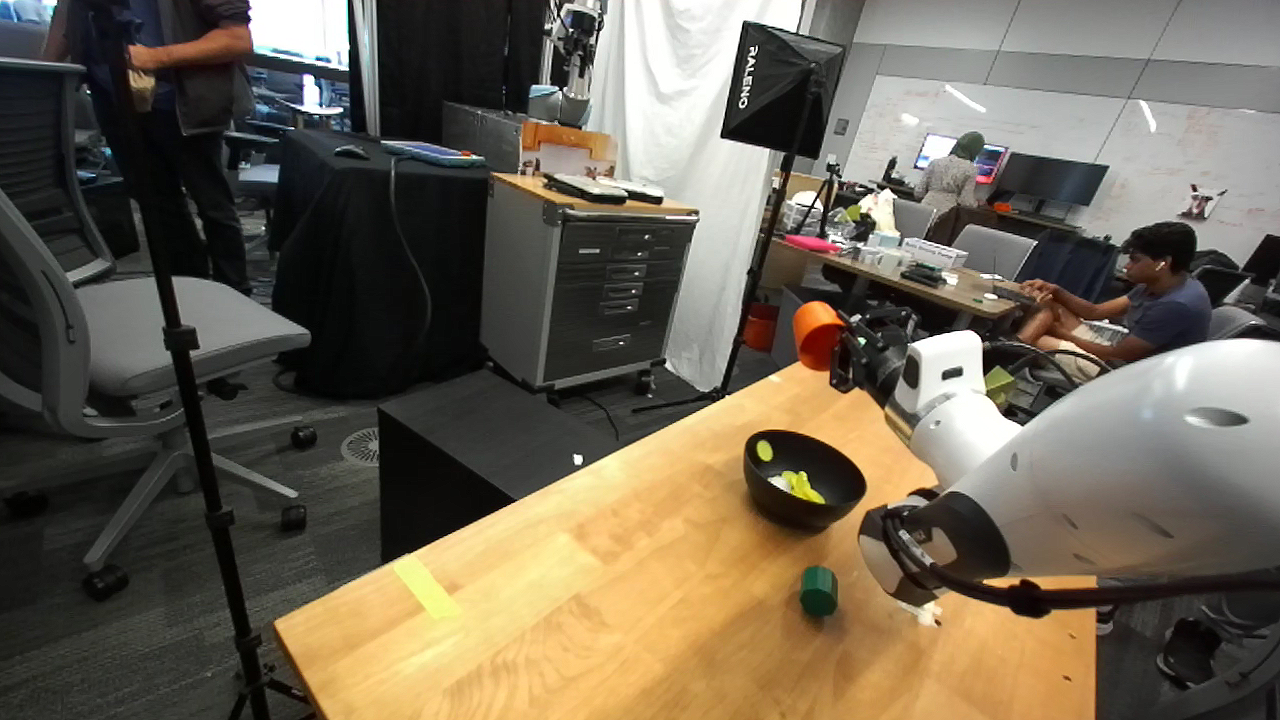

In [8]:
import PIL.Image
import cv2
import numpy as np

# gray = cv2.cvtColor(np.ones((100, 100, 3), dtype=np.uint8), cv2.COLOR_BGR2RGB)

PIL.Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_BGRA2RGB))

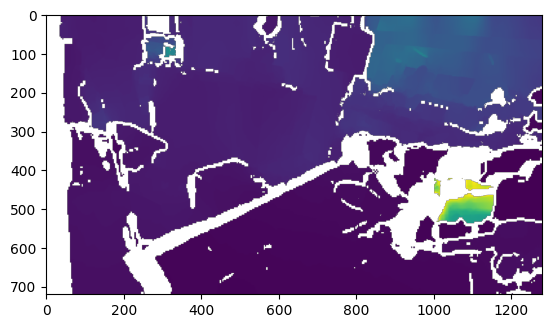

In [9]:
import matplotlib.pyplot as plt
plt.imshow(depth_array)

In [10]:
depth_array[100,100]

1809.3602

In [ ]:
import h5py

with h5py.File(path + "/" + wo_prefix(metadata["hdf5_path"]), "r") as f:
    print(f.keys())
    print(f["action"].keys())
    print(f["observation"].keys())
    # print(f["observation"]["camera_extrinsics"].keys())
    print()

    Teef2base = T_from_xyzrpy(f["observation"]["robot_state"]["cartesian_position"][frame_id])
    print(Teef2base)

    Teef2cam = np.linalg.inv(Tcam2base) @ Teef2base
    print(Teef2cam)

<KeysViewHDF5 ['action', 'observation']>
<KeysViewHDF5 ['cartesian_position', 'cartesian_velocity', 'gripper_position', 'gripper_velocity', 'joint_position', 'joint_velocity', 'robot_state', 'target_cartesian_position', 'target_gripper_position']>
<KeysViewHDF5 ['camera_extrinsics', 'camera_type', 'controller_info', 'robot_state', 'timestamp']>

[[ 0.33003687 -0.26718148  0.90536717  0.57428515]
 [ 0.85689524 -0.31754139 -0.40607636 -0.05497295]
 [ 0.39598763  0.90982499  0.12414617  0.13376018]
 [ 0.          0.          0.          1.        ]]
[[-0.79506745  0.57317512 -0.19833818  0.29913386]
 [-0.39737146 -0.73931298 -0.54361038  0.03627771]
 [-0.45821793 -0.35339298  0.81556712  0.56310692]
 [ 0.          0.          0.          1.        ]]


In [12]:
import open3d as o3d
import numpy as np

from open3d_RGBD import getOpen3DFromTrimeshScene
from trimesh_URDF import getURDF
from trimesh_render import lookAt

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
eef = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
eef.transform(Teef2cam)
pcd = o3d.geometry.PointCloud()

# Initialize the pointcloud viewer
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Point Cloud")

vis.add_geometry(origin)
vis.add_geometry(eef)
vis.add_geometry(pcd)

vis.get_render_option().point_size = 1
vis.get_render_option().background_color = np.asarray([0, 0, 0])

view_control = vis.get_view_control()
view_control.set_constant_z_far(1000)

# Retrieve the camera parameters
camera_params = view_control.convert_to_pinhole_camera_parameters()
# Set the extrinsic parameters, yz_flip is for Open3D camera configuration
camera_pose = lookAt(eye=np.array([0., 0., -1.]), target=np.array([0. ,0., 0.]), up=np.array([0.0, -1.0, 0.0]), yz_flip=True)
camera_params.extrinsic = np.linalg.inv(camera_pose)
# Set the camera parameters
view_control.convert_from_pinhole_camera_parameters(camera_params)

/home/ubuntu/miniforge3/envs/openpi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


True

In [13]:
im_rgb = o3d.geometry.Image(cv2.cvtColor(image_array, cv2.COLOR_BGRA2RGB))
im_d = o3d.geometry.Image(depth_array)

im_rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    im_rgb,
    im_d,
    depth_scale=1000.0,
    convert_rgb_to_intensity=False
)

width = image_array.shape[1]
height = image_array.shape[0]

new_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(im_rgbd, o3d.camera.PinholeCameraIntrinsic(width=width, height=height, intrinsic_matrix=intrinsics))

In [13]:
# new_pcd.transform(CAMERA_TO_WORLD)

pcd.points = new_pcd.points
pcd.colors = new_pcd.colors
vis.update_geometry(pcd)

# Update the visualizer
vis.poll_events()
vis.update_renderer()

vis.run()